## Hong Kong Property Webscraper With Selenium 

![image](https://hkslash.com/api/files/logos/9cc497e9e8f743c2a037cc9ac4c91ed5)

### Objective: 
1. Scrape Property Listings of All Price Ranges Using Selenium
2. Data Preprocessing to filter out Hong Kong, Kowloon, and New Territories District
3. Perform EDA to Draw Insights

In [1]:
# 1: 

# Import BeautifulSoup library
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time

In [6]:
# Define Driver
driver = webdriver.Chrome('/Applications/Chromedriver')
URL = "https://en.hkp.com.hk/?gclid=EAIaIQobChMI1NyM8ueJ5gIV2F1gCh0OkAjnEAAYASAAEgKcl_D_BwE"
driver.get(URL)

html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

# Define Price Range of Listings
Price_Range = "<$4M"   
#Price_Range = "$4-6M" 
#Price_Range = "$15-20M"  
#Price_Range = "$20-50M"  
#Price_Range = "$50-100M" 
#Price_Range = "<$100M" 

# Click on Target Price Range
driver.find_element_by_link_text(Price_Range).click()


old_tab=driver.window_handles[0]

# Wait for Target Element to Show
WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'pagination')))

html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

df = pd.DataFrame(columns = ['Price Range','District','Saleable Area ft2','Gross Area ft2','Floor',\
                             'Price1 M','Price2 M','Price3 M','Monthly Payment',\
                             'Property Number','Updated Date','Desc'])

# For loop to iterate the target number of pages that we want to scrape
for page in range(1,3):
    print(page)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    count=0

# For loop to iterate all the available listings and open a new driver for each of them
    for i in soup.find_all(class_='stock_grid'):
        sublink = i.attrs['data-value']
        #print(sublink)
        subdriver = webdriver.Chrome('/Applications/Chromedriver')
        URL = sublink
        subdriver.get(URL)

        html = subdriver.page_source    
        soup = BeautifulSoup(html, "html.parser")

        District = np.nan
        Saleable_Area = np.nan
        Gross_Area = np.nan
        Floor = np.nan
        Price1 = np.nan
        Price2 = np.nan
        Price3 = np.nan
        Monthly_Payment = np.nan
        Property_Number = np.nan
        Updated_Date = np.nan
        Desc = np.nan   

        count += 1
        subcount = 0
        for k in soup.find_all(class_='subjectTitle'):
            subcount += 1
            text_value = k.parent.text.replace('\n','').replace('\t','')

            if "District" in text_value:
                District = text_value.replace("District","").replace(":","").strip()
            if "Saleable Area" in text_value:
                Saleable_Area = text_value.replace("Saleable Area","").replace(":","")\
                                            .replace("(EfficiencyRatio","")\
                                            .replace(")","").strip()
                if "-" in Saleable_Area:
                    Saleable_Area = np.nan
            if "Gross Area" in text_value:
                Gross_Area = text_value.replace("Gross Area","").replace(":","").strip()
                if "-" in Gross_Area:
                    Gross_Area = np.nan
            if "Floor" in text_value:
                Floor = text_value.replace("Floor","").replace(":","").strip()
            if "Monthly Payment" in text_value:
                Monthly_Payment = text_value.replace("Monthly Payment(HK$)","").replace(":","")\
                                            .replace("$","").strip()
            if "Property Number" in text_value:
                Property_Number = text_value.replace("Property Number","").replace(":","").strip()
            if "Updated Date" in text_value:
                Updated_Date = text_value.replace("Updated Date","").replace(":","").strip()
            if "Description" in text_value:
                Desc = text_value.replace("Description","").replace(":","").strip()

        j_count = 0
        for j in soup.find_all(class_='sell_desc_color'):
            Price = j.parent.text.replace('\n','').replace('\t','')
            j_count += 1
            if j_count == 1:
                if "waived" not in Price:
                    Price1 = Price.replace("Price(HK$)","").replace(":","")\
                                  .replace("$","").strip()
                    Price3 = Price1
            if j_count == 2:
                if "waived" in Price:
                    Price2 = Price.replace("Price(HK$)","").replace(":","")\
                                  .replace("$","").strip()
                    Price3 = Price2
            if j_count >= 2:
                break

        df = df.append({'Price Range': Price_Range,\
                        'District': District, 'Saleable Area ft2': Saleable_Area,\
                        'Gross Area ft2': Gross_Area, 'Floor': Floor, 'Price1 M': Price1,\
                        'Price2 M': Price2, 'Price3 M': Price3, 'Monthly Payment': Monthly_Payment,\
                        'Property Number': Property_Number, 'Updated Date': Updated_Date,\
                        'Desc': Desc}, ignore_index=True)

        subdriver.close()

    #print(count)


    try:
        e = driver.find_element_by_link_text(str(page+1))
        driver.execute_script("arguments[0].click();", e)
        time.sleep(20)
    except:
        e = driver.find_element_by_link_text("»")
        driver.execute_script("arguments[0].click();", e)
        time.sleep(20)
    
    WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'pagination')))

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

1
2


In [7]:
# Function to clean data columns through regex
def to_numeric(x):
    if type(x) == str:
        return float(re.search('^([0-9]+,?)*[0-9]+\.?[0-9]*', x).group().replace(",",""))
    else:
        return x

# Applied it to columns
df["Saleable Area ft2"] = df["Saleable Area ft2"].apply(lambda x: to_numeric(x))
df["Gross Area ft2"] = df["Gross Area ft2"].apply(lambda x: to_numeric(x))
df["Price1 M"] = df["Price1 M"].apply(lambda x: to_numeric(x))
df["Price2 M"] = df["Price2 M"].apply(lambda x: to_numeric(x))
df["Price3 M"] = df["Price3 M"].apply(lambda x: to_numeric(x))
df["Monthly Payment"] = df["Monthly Payment"].apply(lambda x: to_numeric(x))

In [9]:
df.head(10)

,Price Range,District,Saleable Area ft2,Gross Area ft2,Floor,Price1 M,Price2 M,Price3 M,Monthly Payment,Property Number,Updated Date,Desc
0,<$4M,Kowloon Tseung Kwan O,381.0,524.0,High,NaN,2.77,2.77,6459.0,H200059230,03/12/2019,"Bright & Open View, Mountain View, 2 Bedrooms,..."
1,<$4M,New Territories Sai Kung,NaN,NaN,NaN,3.99,NaN,3.99,9304.0,H200095696,29/11/2019,NaN
2,<$4M,Hong Kong Aberdeen / Wong Chuk Hang,385.0,498.0,Middle,NaN,2.90,2.90,6763.0,H100089598,27/11/2019,NaN
3,<$4M,Kowloon Yau Yat Chuen/Shek Kip Mei,284.0,NaN,NaN,NaN,2.68,2.68,6250.0,H200089535,16/11/2019,NaN
4,<$4M,Kowloon Tseung Kwan O,385.0,NaN,High,NaN,2.70,2.70,6296.0,H200099894,03/12/2019,NaN
5,<$4M,"Hong Kong Admiralty, Wan Chai, Causeway Bay",189.0,270.0,Low,3.80,NaN,3.80,8861.0,H100090549,18/11/2019,"Building View, 2 Bedrooms, 2 Sitting-rooms, North"
6,<$4M,Kowloon Wong Tai Sin,443.0,572.0,NaN,NaN,2.69,2.69,6273.0,H200078269,13/11/2019,"Mountain View, 2 Bedrooms, 2 Sitting-rooms, North"
7,<$4M,New Territories Sai Kung,355.0,NaN,Middle,4.45,2.16,2.16,10377.0,H200055644,14/11/2019,1 Sitting-room
8,<$4M,Hong Kong Sai Wan Ho,352.0,465.0,Middle,3.70,NaN,3.70,8628.0,H100091526,02/12/2019,"2 Bedrooms, 1 Sitting-room"
9,<$4M,Kowloon Sau Mau Ping,443.0,NaN,Low,NaN,3.00,3.00,6996.0,H200088027,01/12/2019,"Excellent Choice For First Time Buyer, Excelle..."


In [1]:
import pandas as pd
import re

# For Plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(color_codes=True) #overide maplot libs ugly colours.

<b>Assumptions:</b>
1. The plots are dependent to the page that our webscraper scraped, so the availability of the listings in each 
   district varies with how much data we scraped
2. This is only reflecting Hong Kong Property's individual listings. Another option is to add in different web
   scrapers to find different listings 

In [2]:
df1 = pd.read_csv('df01.csv')
df2 = pd.read_csv('df02.csv')
df3 = pd.read_csv('df03.csv')
df4 = pd.read_csv('df04.csv')
df5 = pd.read_csv('df05.csv')
df6 = pd.read_csv('df06.csv')
df7a = pd.read_csv('df07a.csv')
df7b = pd.read_csv('df07b.csv')
df8 = pd.read_csv('df08.csv')
df9 = pd.read_csv('df09.csv')

In [3]:
df1.drop(columns=['Unnamed: 0','Unnamed: 0.1',],inplace=True)
df2.drop(columns=['Unnamed: 0','Title'],inplace=True)
df3.drop(columns=['Unnamed: 0','Title'],inplace=True)
df4.drop(columns=['Unnamed: 0','Title'],inplace=True)
df5.drop(columns=['Unnamed: 0','Title'],inplace=True)
df6.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
df7a.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
df7b.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
df8.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
df9.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)

In [4]:
listdf = [df1, df2, df3, df4, df5, df6, df7a, df7b, df8, df9]
df = pd.concat(listdf)

In [5]:
# Filtering Price Range of Hong Kong Listings v Price
hkdf = df[df['District'].str.contains("Hong Kong")==True]
hkdf = hkdf[hkdf['Price Range'] != '>$100M']
hkdf

,Price Range,District,Saleable Area ft2,Gross Area ft2,Floor,Price1 M,Price2 M,Price3 M,Monthly Payment,Property Number,Updated Date,Desc
0,<$4M,Hong Kong Aberdeen / Wong Chuk Hang,385.0,498.0,Middle,NaN,2.9,2.9,6763.0,H100089598,27/11/2019,NaN
2,<$4M,"Hong Kong Admiralty, Wan Chai, Causeway Bay",189.0,270.0,Low,3.8,NaN,3.8,8861.0,H100090549,18/11/2019,"Building View, 2 Bedrooms, 2 Sitting-rooms, North"
6,<$4M,Hong Kong Sai Wan Ho,352.0,465.0,Middle,3.7,NaN,3.7,8628.0,H100091526,02/12/2019,"2 Bedrooms, 1 Sitting-room"
10,<$4M,Hong Kong Quarry Bay,267.0,420.0,Low,3.7,NaN,3.7,8628.0,H100042511,09/11/2019,NaN
12,<$4M,Hong Kong Aberdeen / Wong Chuk Hang,407.0,513.0,NaN,NaN,3.5,3.5,8162.0,H100080789,02/10/2019,"Open Space Design, Bright & Open View, Sea Vie..."
...,...,...,...,...,...,...,...,...,...,...,...,...
142,$50-100M,Hong Kong Happy Valley/East Mid Level,1531.0,1955.0,Low,55.0,NaN,55.0,106879.0,H100056977,29/11/2019,"3 Bedrooms, 1 Sitting-room, West"
148,$50-100M,Hong Kong Stanley/Tai Tam/Shek O,2584.0,2672.0,NaN,88.8,NaN,88.8,172562.0,H100018549,20/11/2019,"Excellent Choice For Investor Or End-User, Sea..."
149,$50-100M,Hong Kong Happy Valley/East Mid Level,2491.0,3500.0,Middle,75.0,NaN,75.0,145745.0,H100017033,23/11/2019,"4 Bedrooms, 2 Sitting-rooms"
153,$50-100M,Hong Kong Happy Valley/East Mid Level,1696.0,2000.0,Low,58.5,NaN,58.5,113681.0,H100023757,01/11/2019,"Terrace, Newly Renovated, Building View, 3 Bed..."


In [6]:
mpl.rcParams['figure.figsize'] = [20, 8] #default figure size

# Grouping all Hong Kong Districts and Price Range together and count --> New DataFrame
hkgroup_df = hkdf.groupby(['District','Price Range'])
hkgroup_ndf = pd.DataFrame(hkgroup_df.size().reset_index(name='Listing'))
hkgroup_ndf

,District,Price Range,Listing
0,Hong Kong Aberdeen / Wong Chuk Hang,$20-50M,1
1,Hong Kong Aberdeen / Wong Chuk Hang,$4-6M,2
2,Hong Kong Aberdeen / Wong Chuk Hang,$6-8M,1
3,Hong Kong Aberdeen / Wong Chuk Hang,$8-10M,3
4,Hong Kong Aberdeen / Wong Chuk Hang,<$4M,4
...,...,...,...
79,Hong Kong Western/Sheung Wan Central,$20-50M,28
80,Hong Kong Western/Sheung Wan Central,$4-6M,1
81,Hong Kong Western/Sheung Wan Central,$50-100M,5
82,Hong Kong Western/Sheung Wan Central,$6-8M,7


Text(0.5, 1.0, 'Listings of Hong Kong District Properties')

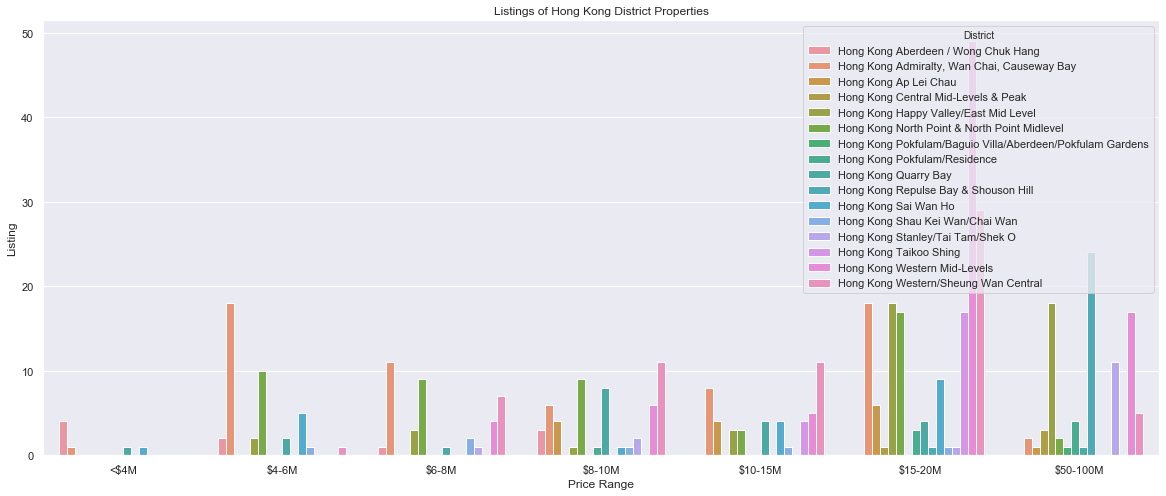

In [7]:
# Listings of Hong Kong District Plot
hkdfplot = sns.barplot(data=hkgroup_ndf, x = 'Price Range',y ="Listing", hue="District", order = ['<$4M','$4-6M','$6-8M', '$8-10M', '$10-15M','$15-20M','$50-100M'])
hkdfplot.set_title('Listings of Hong Kong District Properties')

Text(0.5, 1.0, 'Listings of Kowloon District Properties')

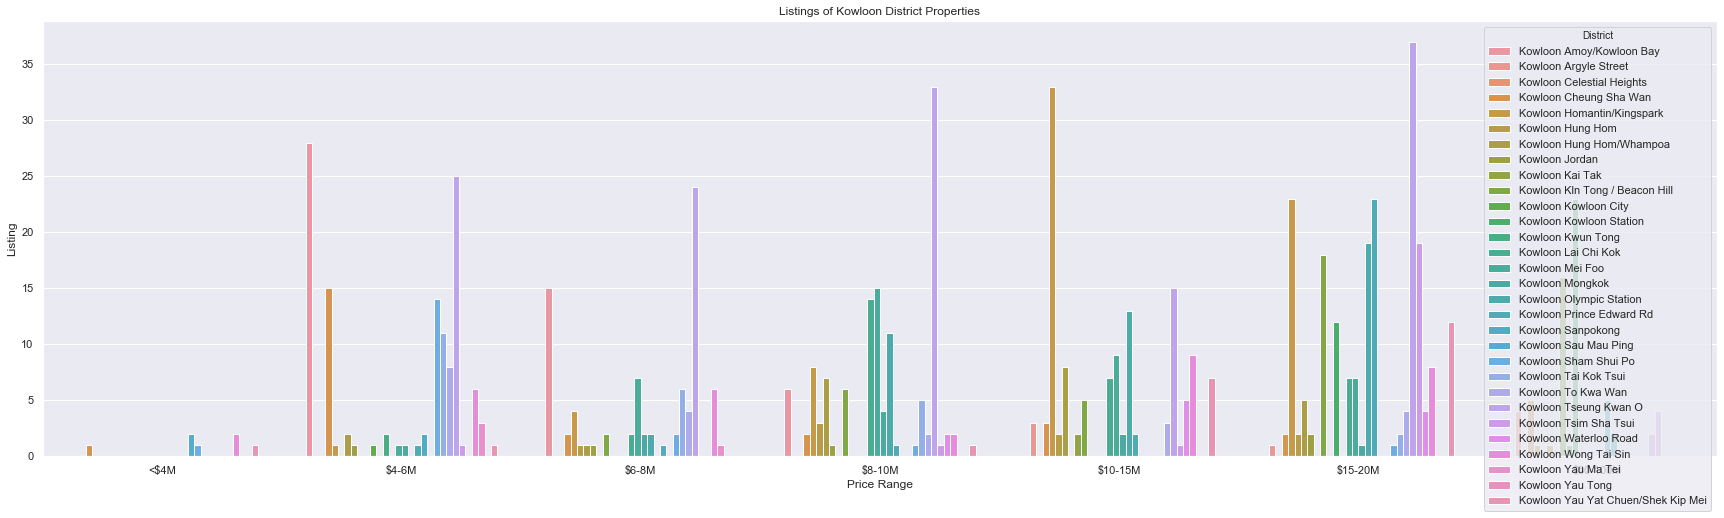

In [8]:
# Now for Kowloon

mpl.rcParams['figure.figsize'] = [30, 8] #default figure size

# Filtering Price Range of Kowloon Listings v Price
kldf = df[df['District'].str.contains("Kowloon")==True]
kldf = kldf[kldf['Price Range'] != '>$100M']

# Grouping all Kowloon Districts and Price Range together and count --> New DataFrame
klgroup_df = kldf.groupby(['District','Price Range'])
klgroup_newdf = pd.DataFrame(klgroup_df.size().reset_index(name='Listing'))
klgroup_newdf

# Listings of Kowloon District Plot
kldfplot = sns.barplot(data=klgroup_newdf, x = 'Price Range',y ="Listing", hue="District", order = ['<$4M','$4-6M','$6-8M', '$8-10M', '$10-15M','$15-20M','$50-100M'])
kldfplot.set_title('Listings of Kowloon District Properties')

Text(0.5, 1.0, 'Listings of New Territories District Properties')

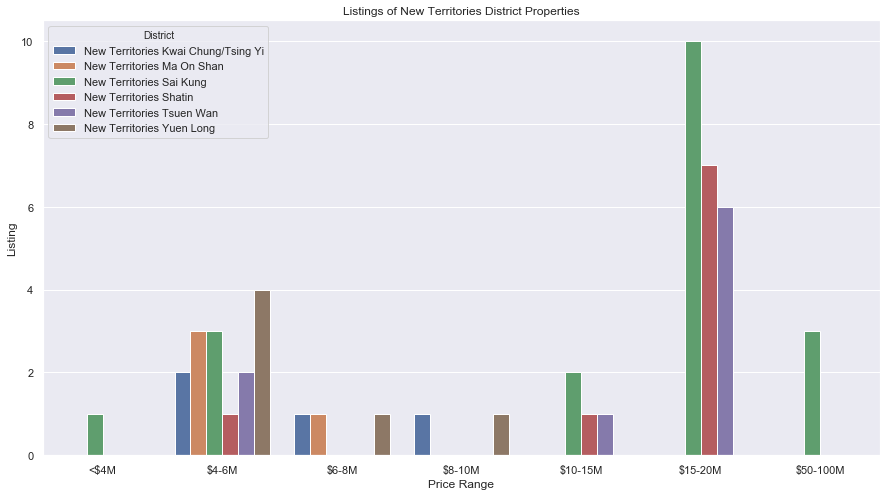

In [9]:
# Now for New Territories

mpl.rcParams['figure.figsize'] = [15, 8] #default figure size

# Filtering Price Range of Kowloon Listings v Price
ntdf = df[df['District'].str.contains("New Territories")==True]
ntdf = ntdf[ntdf['Price Range'] != '>$100M']

# Grouping all Kowloon Districts and Price Range together and count --> New DataFrame
ntgroup_df = ntdf.groupby(['District','Price Range'])
ntgroup_newdf = pd.DataFrame(ntgroup_df.size().reset_index(name='Listing'))
ntgroup_newdf

# Listings of Kowloon District Plot
ntdfplot = sns.barplot(data=ntgroup_newdf, x = 'Price Range',y ="Listing", hue="District", order = ['<$4M','$4-6M','$6-8M', '$8-10M', '$10-15M','$15-20M','$50-100M'])
ntdfplot.set_title('Listings of New Territories District Properties')